In [20]:
%cd ../datasets

from roboflow import Roboflow
rf = Roboflow(api_key="FDR9XzPY1Y45gxx3F6AJ")
project = rf.workspace("marco-joel-isidro-btxny").project("coronas-endodoncias-caries-impactados")
version = project.version(2)
dataset = version.download("coco")
                

This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.


/Users/diegosarina/Development/personal/diegosarina-ceia_publico/vpc-II/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Coronas,-Endodoncias,-Caries,-impactados-2 in coco:: 100%|██████████| 1941/1941 [00:00<00:00, 2299.86it/s]


In [28]:
%cd ../datasets/

from roboflow import Roboflow
rf = Roboflow(api_key="FDR9XzPY1Y45gxx3F6AJ")
project = rf.workspace("marco-joel-isidro-btxny").project("coronas-endodoncias-caries-impactados")
version = project.version(1)
dataset = version.download("coco")
                

This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.


/Users/diegosarina/Development/personal/diegosarina-ceia_publico/vpc-II/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Coronas,-Endodoncias,-Caries,-impactados-1 in coco:: 100%|██████████| 809/809 [00:01<00:00, 711.77it/s]


# Análisis Exploratorio de Datos (EDA)


Este notebook está dedicado a realizar un análisis exploratorio de un dataset de imágenes dentales, que hemos alojado en la plataforma Roboflow. Puedes acceder al dataset desde el siguiente enlace:

- [Acceder al Dataset en Roboflow](https://app.roboflow.com/marco-joel-isidro-btxny/coronas-endodoncias-caries-impactados)

El propósito de este análisis es comprender mejor las características y distribuciones del dataset, lo cual nos permitirá identificar posibles patrones, desbalances de clases y otras propiedades importantes para el desarrollo de nuestros modelos de machine learning.

Para mantener el repositorio organizado y evitar subir grandes archivos, el dataset ha sido excluido del control de versiones mediante .gitignore. Sin embargo, el análisis realizado en este notebook corresponde directamente al dataset mencionado.

Este EDA nos proporcionará las siguientes métricas y visualizaciones clave:

- Distribución de las clases en el dataset.
- Número total de imágenes y anotaciones.
- Frecuencia de objetos por clase en cada imagen.
- Distribución del tamaño de los bounding boxes.
- Análisis del desbalance de clases y co-ocurrencia de objetos.

Estas métricas nos permitirán tomar decisiones fundamentadas para el preprocesamiento y optimización de los modelos.

>NOTA: Inicialmente trabajamos con un dataset que presentaba etiquetas incorrectas, lo que resultó en un bajo rendimiento de nuestros modelos. Posteriormente, logramos encontrar una versión mejorada del mismo dataset, con etiquetas correctas y enfocada en el mismo dominio específico. En este documento, analizamos esta nueva versión, mientras que en la presentación se discute en detalle el problema original de etiquetado y su impacto en los resultados.

In [31]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def load_coco_json(json_path):
    """
    Carga los datos de un archivo JSON en formato COCO y devuelve DataFrames para imágenes, anotaciones y categorías.
    """
    
    with open(json_path, 'r') as f:
        coco_data = json.load(f)
    
    # Crear DataFrames
    df_images = pd.DataFrame(coco_data['images'])
    df_annotations = pd.DataFrame(coco_data['annotations'])
    df_categories = pd.DataFrame(coco_data['categories'])
    
    # Mapeo de categorías
    category_mapping = {row['id']: row['name'] for _, row in df_categories.iterrows()}
    df_annotations['category_name'] = df_annotations['category_id'].map(category_mapping)
    
    return df_images, df_annotations, df_categories

df_images, df_annotations, categories = load_coco_json('../datasets/Coronas,-Endodoncias,-Caries,-impactados-1/train/_annotations.coco.json')


In [37]:
print(f"\n--- Dataset info ---")

# Total de anotaciones
total_annotations = len(df_annotations)
print(f"Total de anotaciones: {total_annotations}")

# Total de imágenes
total_images = len(df_images)
print(f"Total de imágenes: {total_images}")

# Distribución de las clases
class_distribution = df_annotations['category_name'].value_counts()
print(f"\nDistribución de clases:\n{class_distribution}")


--- Dataset info ---
Total de anotaciones: 3974
Total de imágenes: 805

Distribución de clases:
category_name
corona        1486
caries        1411
endodoncia    1043
implante        34
Name: count, dtype: int64


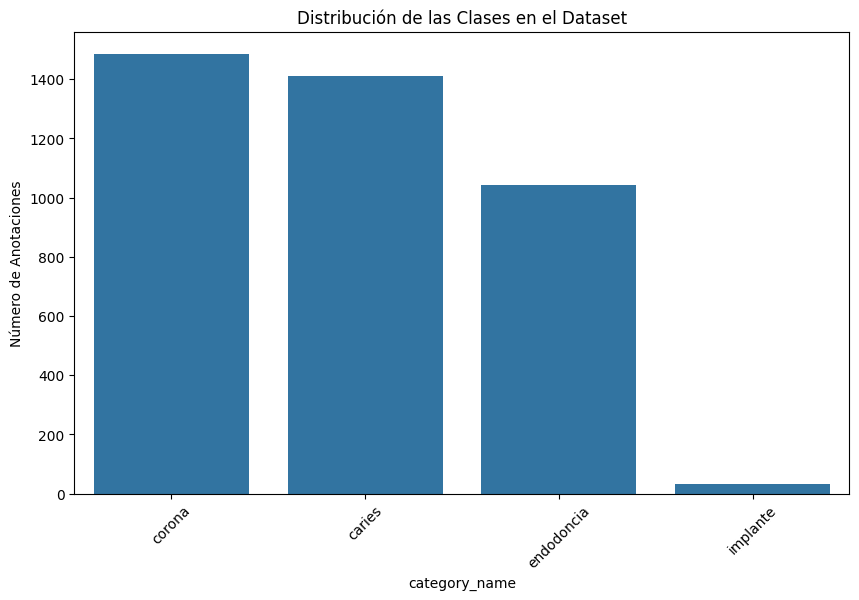

In [38]:
# Visualización de la distribución de clases
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title(f'Distribución de las Clases en el Dataset')
plt.ylabel('Número de Anotaciones')
plt.xticks(rotation=45)
plt.show()

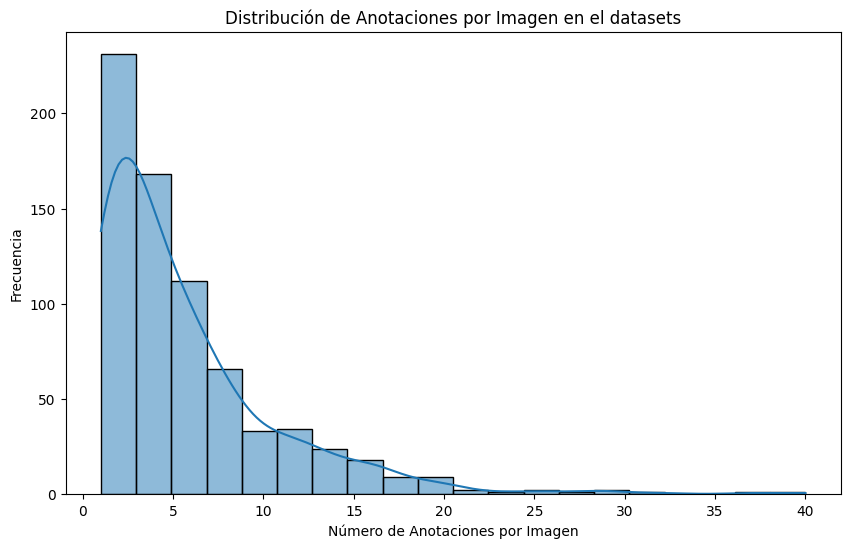

In [39]:
# Distribución de anotaciones por imagen
annotations_per_image = df_annotations.groupby('image_id').size()
plt.figure(figsize=(10, 6))
sns.histplot(annotations_per_image, bins=20, kde=True)
plt.title(f'Distribución de Anotaciones por Imagen en el datasets')
plt.xlabel('Número de Anotaciones por Imagen')
plt.ylabel('Frecuencia')
plt.show()

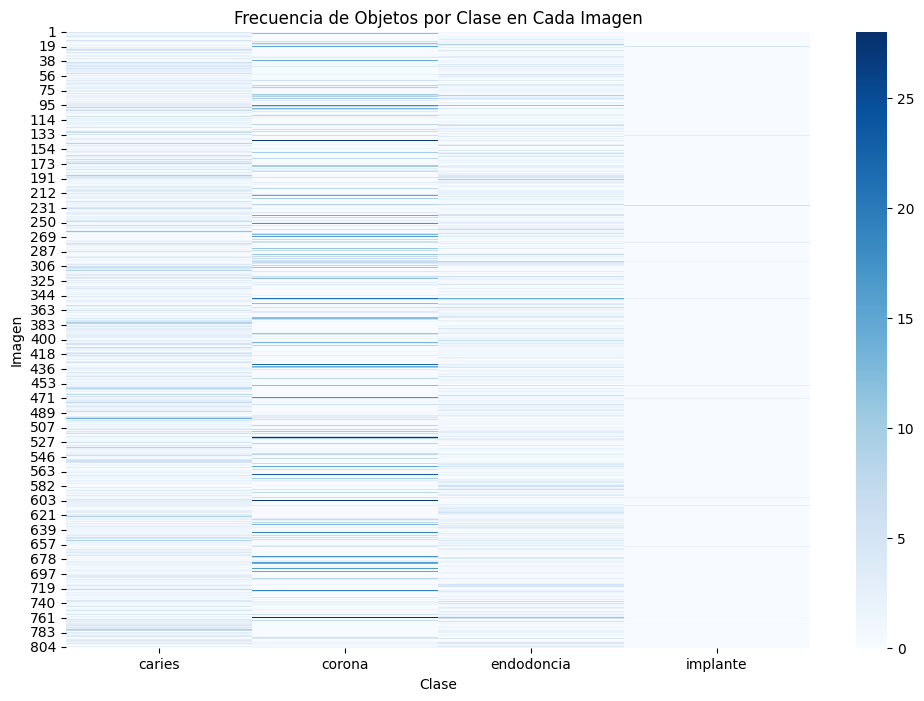

In [41]:
# Crear un DataFrame que asocie imágenes con clases a partir de las anotaciones
class_per_image = pd.DataFrame({
    'image_id': df_annotations['image_id'],
    'class': df_annotations['category_name']
})

# Contar la cantidad de objetos de cada clase por imagen
class_distribution = class_per_image.groupby(['image_id', 'class']).size().unstack(fill_value=0)

# Visualización: Mapa de calor de la frecuencia de objetos por clase en cada imagen
plt.figure(figsize=(12, 8))
sns.heatmap(class_distribution, cmap='Blues', cbar=True)
plt.title('Frecuencia de Objetos por Clase en Cada Imagen')
plt.xlabel('Clase')
plt.ylabel('Imagen')
plt.show()

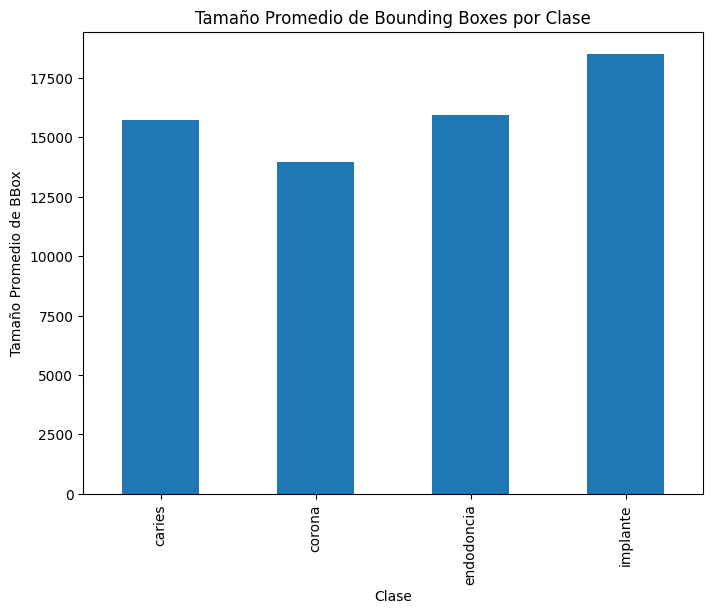

In [46]:
# Tamaño Promedio de los Bounding Boxes por Clase
# variabilidad de los tamaños de los objetos que el modelo necesita detectar.
df_annotations['bbox_area'] = df_annotations['bbox'].apply(lambda x: x[2] * x[3])
bbox_avg_per_class = df_annotations.groupby('category_name')['bbox_area'].mean()

plt.figure(figsize=(8, 6))
bbox_avg_per_class.plot(kind='bar')
plt.title('Tamaño Promedio de Bounding Boxes por Clase')
plt.xlabel('Clase')
plt.ylabel('Tamaño Promedio de BBox')
plt.show()

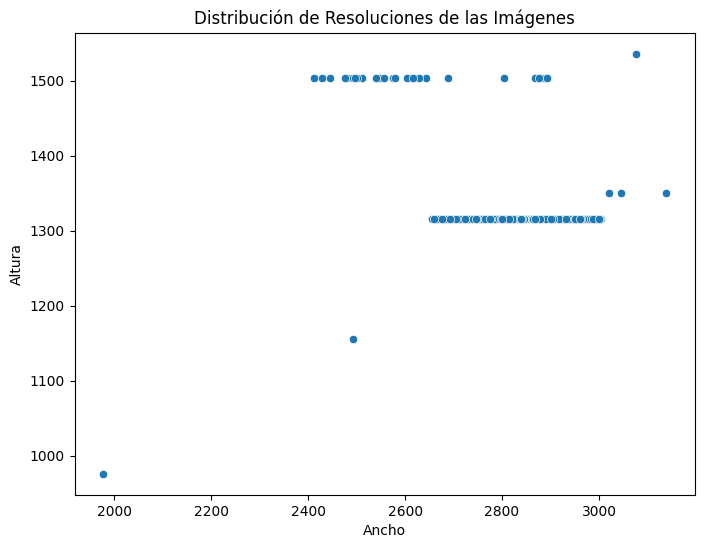

In [49]:
# 4. Distribución de Resoluciones de las Imágenes
image_resolutions = df_images[['height', 'width']].drop_duplicates()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='width', y='height', data=image_resolutions)
plt.title('Distribución de Resoluciones de las Imágenes')
plt.xlabel('Ancho')
plt.ylabel('Altura')
plt.show()

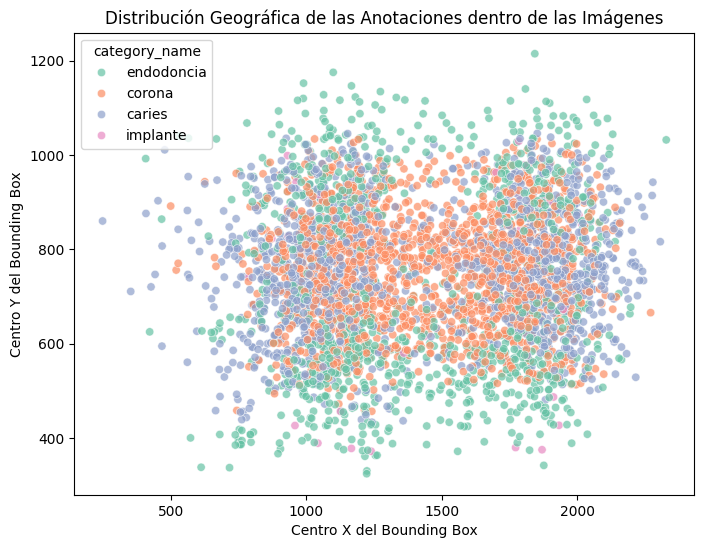

In [54]:
# 8. Distribución geográfica de las anotaciones dentro de la imagen
df_annotations['x_center'] = df_annotations['bbox'].apply(lambda x: x[0] + x[2] / 2)
df_annotations['y_center'] = df_annotations['bbox'].apply(lambda x: x[1] + x[3] / 2)

plt.figure(figsize=(8, 6))
sns.scatterplot(x='x_center', y='y_center', hue='category_name', data=df_annotations, palette='Set2', alpha=0.7)
plt.title('Distribución Geográfica de las Anotaciones dentro de las Imágenes')
plt.xlabel('Centro X del Bounding Box')
plt.ylabel('Centro Y del Bounding Box')
plt.show()